In [1]:
from collections import Counter, defaultdict
import itertools
import random

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, axes3d
import numpy as np
import tqdm

# 1. Implementation

In [2]:
# black cards are dentoed as positive numbers 
# red cards are denoted as negative numbers

class Easy21:
    def _draw_color(self):
        return -1 if np.random.rand() < 1/3 else 1
    
    def _draw_number(self):
        return random.randint(1, 10)
    
    def draw(self):
        return self._draw_color()*self._draw_number()

    def step(self, state, action):
        """
        Args:
            state: A tuple of integers (dealer, players_sum)
            action: "hit" or "stick"
        
        Returns:
            a tuple of (state, reward). None state is a terminal state. 
        """
        dealer, player = state
        action = action.lower()
        
        if action == 'hit':
            player += self.draw()
            if 1 <= player <= 21:
                return (dealer, player), 0
            return None, -1    
        elif action == 'stick':
            while dealer < 17:
                dealer += self.draw()
                if not 1 <= dealer <= 21:
                    return None, 1
            if dealer > player:
                return None, -1
            elif dealer == player:
                return None, 0
            else:
                return None, 1
    
    def initial_state(self):
        return (self._draw_number(), self._draw_number())

# 2. Monte-Carlo Control

In [3]:
def eps_greedy_action(Q, N, state):
    eps = N_0/(N_0 + N[state])
    if np.random.rand() < eps or Q[state, "hit"] == Q[state, "stick"]:
        return "hit" if np.random.rand() < .5 else "stick"
    return "hit" if Q[state, "hit"] > Q[state, "stick"] else "stick"
    
def rollout(Q, N):
    state = env.initial_state()
    res = [state]
    while state is not None:
        action = eps_greedy_action(Q, N, state)
        state, reward = env.step(state, action)
        res.extend((action, state))
    return res, reward

In [4]:
Q = defaultdict(float)
N = Counter()
N_0  = 100

env = Easy21()

for t in tqdm.trange(1000_000):
    roll, g = rollout(Q, N)
    i = 0
    while roll[i] is not None:
        state, action = roll[i], roll[i+1]
        i += 2
        
        N[state, action] += 1
        N[state] += 1
        Q[state, action] += (1/N[state, action]) * (g - Q[state, action])

100%|██████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:15<00:00, 62507.88it/s]


In [5]:
V = {}
states = {s for s, a in Q}
for state in states:
    if Q[state, "hit"] > Q[state, "stick"]:
        V[state] = Q[state, "hit"]
    else:
        V[state] = Q[state, "stick"]

x, y = np.meshgrid(np.arange(1, 11), np.arange(1, 21))
z = np.empty_like(x, dtype=np.float32)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = V[x[i, j], y[i, j]]

Text(0.5, 0.92, 'Monte Carlo Control')

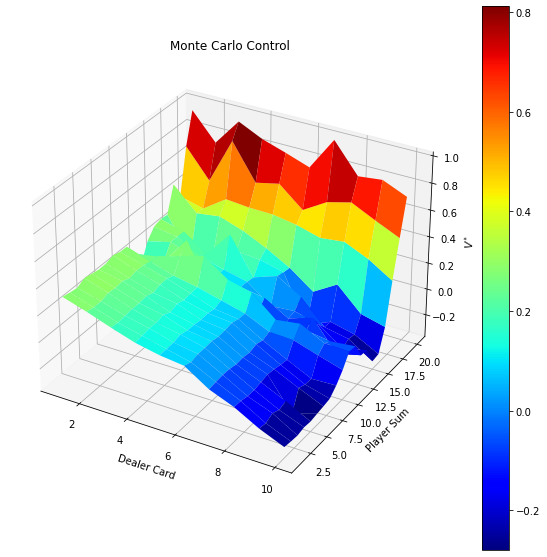

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Dealer Card')
ax.set_ylabel('Player Sum')
ax.set_zlabel('$V^*$')
surf = ax.plot_surface(x, y, z, cmap='jet')
fig.colorbar(surf)
plt.title('Monte Carlo Control')

# TD Learning in Easy 21

In [7]:
Q_star = Q

In [8]:
STATES = list(itertools.product(range(1, 11), range(1, 22)))
N_0 = 100

def compute_mse(Q):
    mse = cnt = 0.0
    for sa in itertools.product(STATES, ("hit", "stick")):
        mse += (Q_star[sa] - Q[sa])**2
        cnt += 1
    return mse/cnt

def run_sarsa(lambda_, num_episodes=1000, learning_curves=False):
    Q = defaultdict(float)
    N = Counter()
    lrs = []
    
    for ep in range(num_episodes):
        E = defaultdict(float)
        state = env.initial_state()
        action = "hit" if np.random.rand() < .5 else "stick"
        while state is not None:
            
            
            next_state, reward = env.step(state, action)
            next_action = eps_greedy_action(Q, N, next_state)
            td_error = reward + Q[next_state, next_action] - Q[state, action]
            
            E[state, action] += 1
            N[state, action] += 1
            N[state] += 1
            
            for sa in itertools.product(STATES, ("hit", "stick")):
                if N[sa] > 0:
                    alpha = 1/N[sa]
                    Q[sa] += alpha * td_error * E[sa]
                    E[sa] *= lambda_
            
            state, action = next_state, next_action
        if learning_curves:
            lrs.append(compute_mse(Q))
    
    if learning_curves:
        return Q, lrs
    else:
        return Q

In [9]:
for (a, b) in Q:
    if a is None:
        print(a, b, Q[a, b])


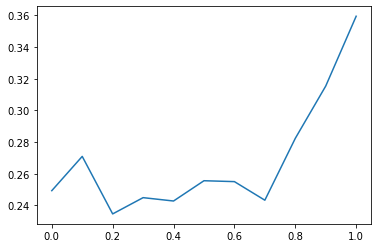

In [10]:
mses = []
lambdas = np.arange(0, 1.01, .1)
for l in lambdas:
    mses.append(compute_mse(run_sarsa(l, 1000)))

plt.plot(lambdas, mses)

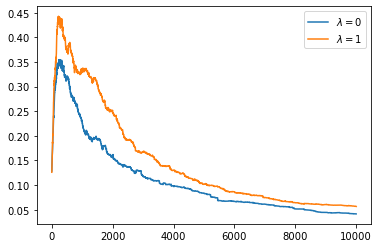

In [11]:
_, lr0 = run_sarsa(0, 10000, True)
_, lr1 = run_sarsa(1, 10000, True)

plt.plot(lr0, label="$\lambda = 0$")
plt.plot(lr1, label="$\lambda = 1$")
plt.legend()

# Linear Function Approximation in Easy21

In [12]:
cubes = list(itertools.product([(1, 4), (4, 7), (7, 10)],
                               [(1, 6), (4, 9), (7, 12), (10, 15), (13, 18), (16, 21)], 
                               ["hit", "stick"]))

def feature(state, action):
    vec = np.zeros(36, )
    if state is None:
        return vec
    dealer, player = state
    
    for i, ((a, b), (c, d), ac) in enumerate(cubes):
        if a <= dealer <= b and c <= player <= d and ac == action:
            vec[i] = 1
    return vec

In [13]:

def compute_mse_fa(w):
    mse = cnt = 0.0
    for s, a in itertools.product(STATES, ("hit", "stick")):
        mse += (Q_star[s, a] - w@feature(s, a))**2
        cnt += 1
    return mse/cnt

def run_sarsa_fa(lambda_, num_episodes=1000, learning_curves=False):
    lrs = []
    w = np.random.randn(36)
    
    for ep in range(num_episodes):
        E = np.zeros(36)
        
        state = env.initial_state()
        action = "hit" if np.random.rand() < .5 else "stick"
        
        while state is not None:    
            next_state, reward = env.step(state, action)
            
            Q_hit   = w @ feature(next_state, "hit")
            Q_stick = w @ feature(next_state, "stick")
            if np.random.rand() < 0.05 or Q_hit == Q_stick:
                next_action = "hit" if np.random.rand() < .5 else "stick"
            elif Q_hit > Q_stick:
                next_action = "hit"
            else:
                next_action = "stick"
            
            Q_next = Q_hit if next_action == "hit" else Q_stick
            
            x = feature(state, action)
            td_error = reward + Q_next - w@x
            E = lambda_*E + x
            w += 0.01*E*td_error
            state, action = next_state, next_action
            
        if learning_curves:
            lrs.append(compute_mse_fa(w))
    
    if learning_curves:
        return w, lrs
    else:
        return w

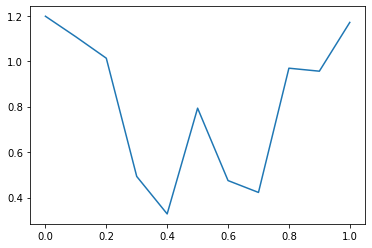

In [14]:
mses = []
lambdas = np.arange(0, 1.01, .1)
for l in lambdas:
    mses.append(compute_mse_fa(run_sarsa_fa(l, 1000)))

plt.plot(lambdas, mses)

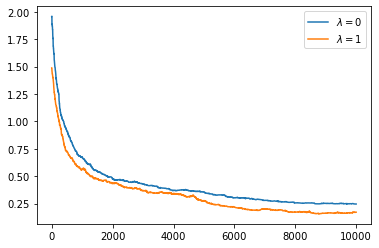

In [15]:
_, lr0 = run_sarsa_fa(0, 10000, True)
_, lr1 = run_sarsa_fa(1, 10000, True)

plt.plot(lr0, label="$\lambda = 0$")
plt.plot(lr1, label="$\lambda = 1$")
plt.legend()